In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Importando Librerias

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# Set seed for experiment reproducibility
seed = 32
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Se cargan las diferentes dependencias necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Conv2D, MaxPooling2D, Reshape

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# !pip3 install requests

import os
import json
import time, hmac, hashlib
import requests

In [5]:
# !pip3 install cbor2

In [6]:
from cbor2 import dumps as cb_dumps
from cbor2 import loads as cb_loads
from cbor2 import load as cb_load


In [7]:
import os
MODELS_DIR = './models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

# Leyendo dataset de entrenamiento y validacion tomado con Edge Impulse y Arduino nano BLE33

In [8]:
# %cd /content/gdrive/MyDrive/Proyecto2_Edge_Tiny

In [9]:
%ls movimientos_recuperacion_con_arduinoble33-export/testing

md_avanzar.34n0f16l.ingestion-65bfb76ddd-n9fzx.cbor
md_avanzar.34n15nl7.ingestion-65bfb76ddd-vl9kr.cbor
md_derecha.34n0hcu2.ingestion-65bfb76ddd-zzcf6.cbor
md_derecha.34n0hjt7.ingestion-65bfb76ddd-vl9kr.cbor
md_izquierda.34n0mu81.ingestion-65bfb76ddd-zzcf6.cbor
md_izquierda.34n0n4fn.ingestion-65bfb76ddd-zzcf6.cbor
md_retroceder.34n0pkb3.ingestion-65bfb76ddd-zzcf6.cbor
md_retroceder.34n0pq8u.ingestion-65bfb76ddd-n9fzx.cbor
standby.34n081ie.ingestion-65bfb76ddd-vl9kr.cbor
standby.34n0892g.ingestion-65bfb76ddd-vl9kr.cbor


## Leyendo un dato para saber como usar la info

In [10]:
# Efficiently deserialize from a file
# RutaFile="/content/gdrive/MyDrive/Proyecto2_Edge_Tiny/movimientos_recuperacion_con_arduinoble33-export/testing/md_avanzar.34n0f16l.ingestion-65bfb76ddd-n9fzx.cbor"
RutaFile = "movimientos_recuperacion_con_arduinoble33-export/testing/md_avanzar.34n0f16l.ingestion-65bfb76ddd-n9fzx.cbor"

with open(RutaFile, 'rb') as fp:
    obj = cb_load(fp,)

In [11]:
type(obj)

dict

In [12]:
obj['payload'].keys()

dict_keys(['device_name', 'device_type', 'interval_ms', 'sensors', 'values'])

In [13]:
len(obj['payload']['values'])

20

In [14]:
# Creando columna
column_list = []
for i in range(len(obj['payload']['sensors'])):
  column_list.append(obj['payload']['sensors'][i]['name'])

In [15]:
column_list

['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ', 'magX', 'magY', 'magZ']

In [16]:
obj['payload']['interval_ms']

50.0

In [17]:
# Creando index
index_list = []
for i in range(len(obj['payload']['values'])):
  index_list.append(obj['payload']['interval_ms']*i)

In [18]:
dataframe = pd.DataFrame(obj['payload']['values'],index=index_list,columns=column_list)

            accX      accY      accZ       gyrX        gyrY       gyrZ       magX       magY      magZ
0.0     0.300472 -2.452261  9.379285   0.305176    0.061035   0.244141   7.141113   9.423828 -1.220703
50.0    0.254384 -2.451064  9.417592  -0.427246    0.305176   0.122070   7.287598   9.423828 -1.525879
100.0   0.327407 -2.444480  9.347562  -0.122070    0.244141   0.061035   7.531738   9.289551 -0.219727
150.0   0.296881 -2.432509  9.335591  -0.610352   -0.183105   0.366211   7.312012  10.070801 -0.061035
200.0   0.265158 -2.460042  9.410410   0.610352   -0.488281   0.183105   7.617188  10.070801 -0.732422
250.0   0.269946 -2.458845  9.442732  -0.122070   -0.610352   0.000000   7.885742   9.118652  0.646973
300.0   0.188543 -2.502539  9.440936   0.366211    0.793457   0.488281   7.226562   9.545898  0.524902
350.0   0.206500 -2.530671  9.411607  -0.854492    3.234863   0.549316   8.288574   9.338379  0.549316
400.0  -6.660070 -2.085948  8.354567  -6.713867  247.741699  60.363770   

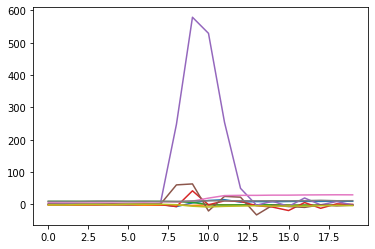

In [19]:
print(dataframe.to_string()) 
Valores = dataframe.iloc[:,:].values
print(Valores.shape)
# print(Valores)
plt.plot(Valores)
plt.show()

# DatosOri1=Valores[7,2][0:-1]
# Datos1=np.array(DatosOri1)
# print(Datos1.shape)
# plt.plot(Datos1)

In [20]:
len(Valores)

20

## Creando Datasets

### Entrenamiento

In [21]:
RutaBase = "movimientos_recuperacion_con_arduinoble33-export/training/"
ValoresTraining = []

lst = os.listdir(RutaBase)
lst.sort()

for elemento in lst[:-8]:
    
    RutaFile= os.path.join(RutaBase,elemento)
    print(elemento)
    with open(RutaFile, 'rb') as fp:
        objTraining = cb_load(fp,)

    dataframeTraining = pd.DataFrame(objTraining['payload']['values'],index=index_list,columns=column_list)
    ValoresTraining.append(dataframeTraining.values)


print("Tamano de ValoresTraining: ",len(ValoresTraining))
DatosTrain = np.concatenate(ValoresTraining,axis=0)
print("Tamano de DatosTrain: ", DatosTrain.shape)

md_avanzar.34n0cvin.ingestion-65bfb76ddd-n9fzx.cbor
md_avanzar.34n0d7mq.ingestion-65bfb76ddd-vl9kr.cbor
md_avanzar.34n0desb.ingestion-65bfb76ddd-zzcf6.cbor
md_avanzar.34n0dm15.ingestion-65bfb76ddd-zzcf6.cbor
md_avanzar.34n0dt47.ingestion-65bfb76ddd-zzcf6.cbor
md_avanzar.34n0e3bn.ingestion-65bfb76ddd-vl9kr.cbor
md_avanzar.34n0ek8g.ingestion-65bfb76ddd-vl9kr.cbor
md_avanzar.34n0eqbt.ingestion-65bfb76ddd-vl9kr.cbor
md_derecha.34n0fjlr.ingestion-65bfb76ddd-zzcf6.cbor
md_derecha.34n0fr3s.ingestion-65bfb76ddd-n9fzx.cbor
md_derecha.34n0g3eg.ingestion-65bfb76ddd-n9fzx.cbor
md_derecha.34n0ga1r.ingestion-65bfb76ddd-zzcf6.cbor
md_derecha.34n0gh2t.ingestion-65bfb76ddd-vl9kr.cbor
md_derecha.34n0gnvr.ingestion-65bfb76ddd-zzcf6.cbor
md_derecha.34n0gv6c.ingestion-65bfb76ddd-vl9kr.cbor
md_derecha.34n0h617.ingestion-65bfb76ddd-zzcf6.cbor
md_izquierda.34n0iprl.ingestion-65bfb76ddd-n9fzx.cbor
md_izquierda.34n0j0mp.ingestion-65bfb76ddd-n9fzx.cbor
md_izquierda.34n0j7in.ingestion-65bfb76ddd-n9fzx.cbor
md_izq

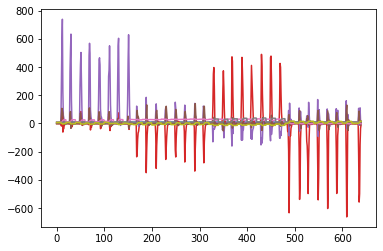

In [22]:
plt.plot(DatosTrain)
plt.show()

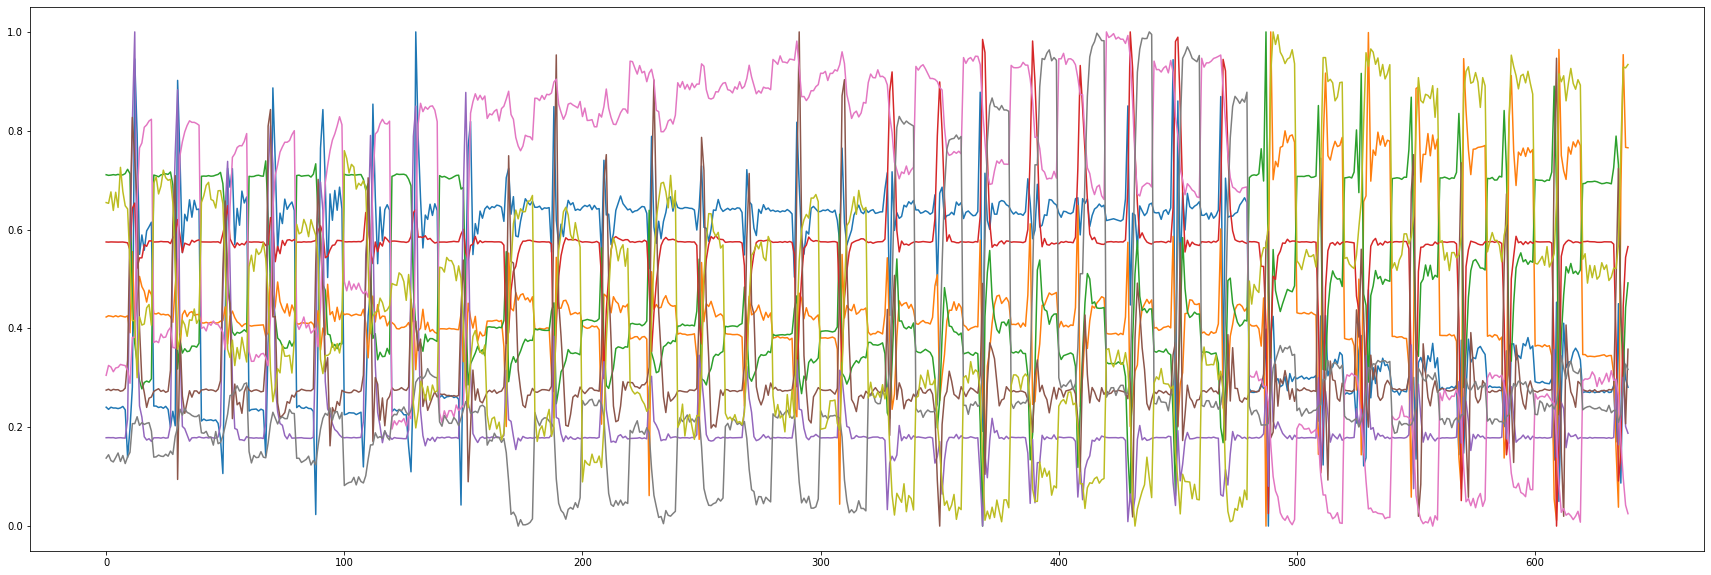

In [23]:
scaler = MinMaxScaler()
scaler.fit(DatosTrain)
DatosN=scaler.transform(DatosTrain)
plt.figure(figsize=(30,10))
plt.plot(DatosN)
plt.show()

In [24]:
for i in range(1,len(DatosTrain)):
  if len(DatosTrain)%i==0:
    print(i)

1
2
4
5
8
10
16
20
32
40
64
80
128
160
320


In [25]:
640/20

32.0

In [26]:
Xtrain=np.zeros((32,20,9))

for i in range(32):
    Xtrain[i,:,0]=DatosN[i*20:(i+1)*20,0].T
    Xtrain[i,:,1]=DatosN[i*20:(i+1)*20,1].T
    Xtrain[i,:,2]=DatosN[i*20:(i+1)*20,2].T
    Xtrain[i,:,3]=DatosN[i*20:(i+1)*20,3].T
    Xtrain[i,:,4]=DatosN[i*20:(i+1)*20,4].T
    Xtrain[i,:,5]=DatosN[i*20:(i+1)*20,5].T
    Xtrain[i,:,6]=DatosN[i*20:(i+1)*20,6].T
    Xtrain[i,:,7]=DatosN[i*20:(i+1)*20,7].T
    Xtrain[i,:,8]=DatosN[i*20:(i+1)*20,8].T
    
print(Xtrain.shape)

(32, 20, 9)


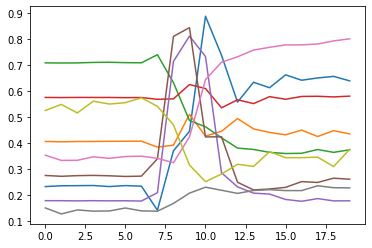

In [27]:
plt.plot(Xtrain[3,:,:])
plt.show()

In [28]:
YtrainIni=np.zeros((32,1))
for i in range(8):
    YtrainIni[i]=0

for i in range(8,16):
    YtrainIni[i]=1

for i in range(16,24):
    YtrainIni[i]=2 

for i in range(24,32):
    YtrainIni[i]=3

# for i in range(32,40):
#     YtrainIni[i]=4

# for i in range(30,36):
#     YtrainIni[i]=5  

# for i in range(36,42):
#     YtrainIni[i]=6

# for i in range(42,48):
#     YtrainIni[i]=7 

print(YtrainIni)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]]


In [29]:
Ytrain= to_categorical(YtrainIni)
print(Ytrain)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


### Validacion

In [30]:
RutaBaseTest = "movimientos_recuperacion_con_arduinoble33-export/testing/"
ValoresTest = []

lst = os.listdir(RutaBaseTest)
lst.sort()

for elemento in lst[:-2]:
    
    RutaFile= os.path.join(RutaBaseTest,elemento)
    print(elemento)
    with open(RutaFile, 'rb') as fp:
        objTest = cb_load(fp,)

    dataframeTest = pd.DataFrame(objTest['payload']['values'],index=index_list,columns=column_list)
    ValoresTest.append(dataframeTest.values)


print("Tamano de ValoresTest: ",len(ValoresTest))
DatosTest = np.concatenate(ValoresTest,axis=0)
print("Tamano de DatosTest: ", DatosTest.shape)

md_avanzar.34n0f16l.ingestion-65bfb76ddd-n9fzx.cbor
md_avanzar.34n15nl7.ingestion-65bfb76ddd-vl9kr.cbor
md_derecha.34n0hcu2.ingestion-65bfb76ddd-zzcf6.cbor
md_derecha.34n0hjt7.ingestion-65bfb76ddd-vl9kr.cbor
md_izquierda.34n0mu81.ingestion-65bfb76ddd-zzcf6.cbor
md_izquierda.34n0n4fn.ingestion-65bfb76ddd-zzcf6.cbor
md_retroceder.34n0pkb3.ingestion-65bfb76ddd-zzcf6.cbor
md_retroceder.34n0pq8u.ingestion-65bfb76ddd-n9fzx.cbor
Tamano de ValoresTest:  8
Tamano de DatosTest:  (160, 9)


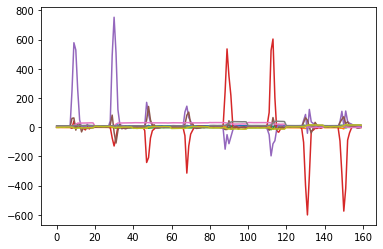

In [31]:
plt.plot(DatosTest)
plt.show()

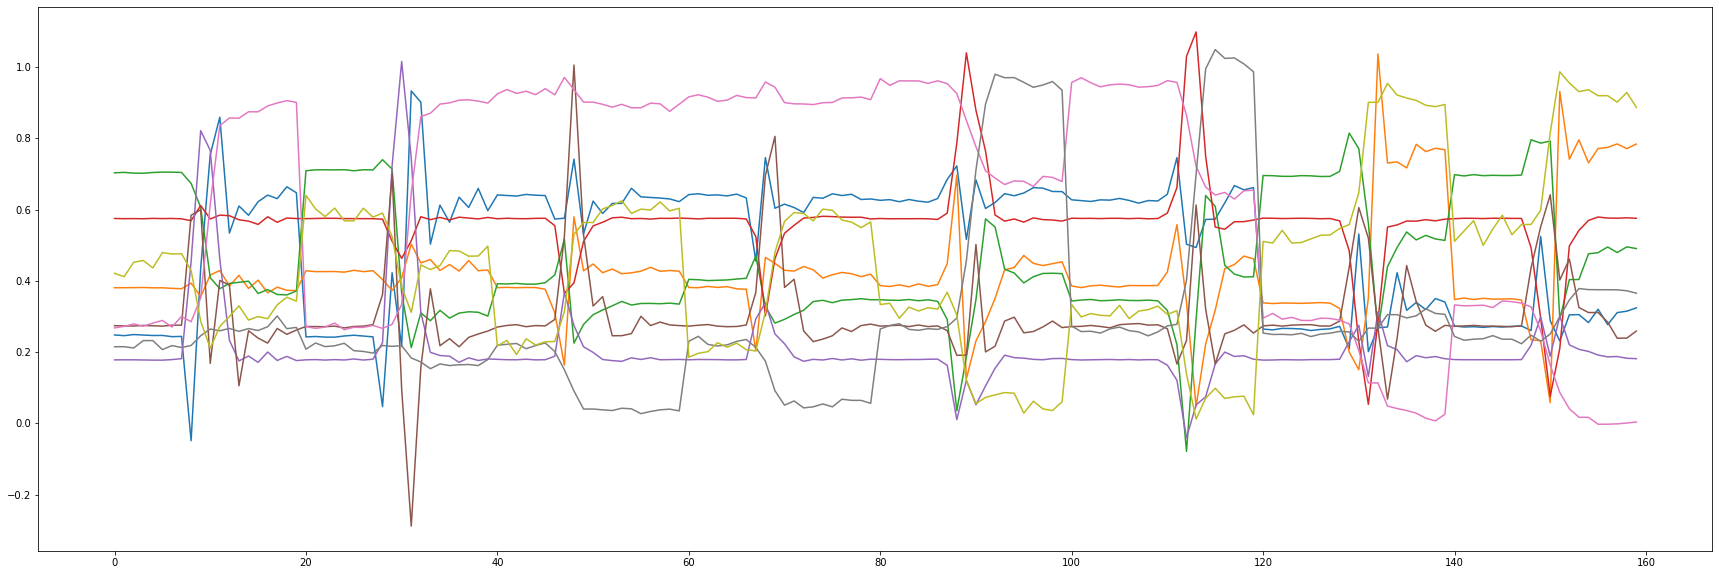

In [32]:
# scalerTest = MinMaxScaler()
# scalerTest.fit(DatosTest)
DatosValN=scaler.transform(DatosTest)
plt.figure(figsize=(30,10))
plt.plot(DatosValN)
plt.show()

In [33]:
160/20

8.0

In [34]:
Xtest=np.zeros((8,20,9))

for i in range(8):
    Xtest[i,:,0]=DatosValN[i*20:(i+1)*20,0].T
    Xtest[i,:,1]=DatosValN[i*20:(i+1)*20,1].T
    Xtest[i,:,2]=DatosValN[i*20:(i+1)*20,2].T
    Xtest[i,:,3]=DatosValN[i*20:(i+1)*20,3].T
    Xtest[i,:,4]=DatosValN[i*20:(i+1)*20,4].T
    Xtest[i,:,5]=DatosValN[i*20:(i+1)*20,5].T
    Xtest[i,:,6]=DatosValN[i*20:(i+1)*20,6].T
    Xtest[i,:,7]=DatosValN[i*20:(i+1)*20,7].T
    Xtest[i,:,8]=DatosValN[i*20:(i+1)*20,8].T
    
print(Xtest.shape)

(8, 20, 9)


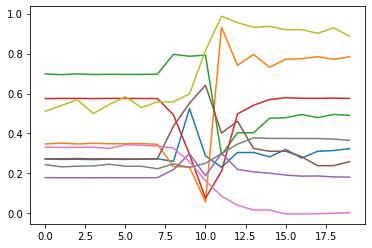

In [35]:
plt.plot(Xtest[7,:,:])
plt.show()

In [36]:
YtestIni=np.zeros((8,1))
for i in range(2):
    YtestIni[i]=0

for i in range(2,4):
    YtestIni[i]=1

for i in range(4,6):
    YtestIni[i]=2 

for i in range(6,8):
    YtestIni[i]=3

# for i in range(32,40):
#     YtestIni[i]=4

# for i in range(30,36):
#     YtestIni[i]=5  

# for i in range(36,42):
#     YtestIni[i]=6

# for i in range(42,48):
#     YtestIni[i]=7 

print(YtestIni)

[[0.]
 [0.]
 [1.]
 [1.]
 [2.]
 [2.]
 [3.]
 [3.]]


In [37]:
Ytest= to_categorical(YtestIni)
print(Ytest)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


# Creando modelo

## Modelo Conv1D

2022-06-12 17:15:45.996524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:15:46.039906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:15:46.040206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 20, 9)          0         
                                                                 
 conv2d (Conv2D)             (None, 1, 20, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 20, 32)         1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 20, 32)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 4)                 2564      
                                                        

2022-06-12 17:15:46.041769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-12 17:15:46.043352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:15:46.043554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:15:46.043714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

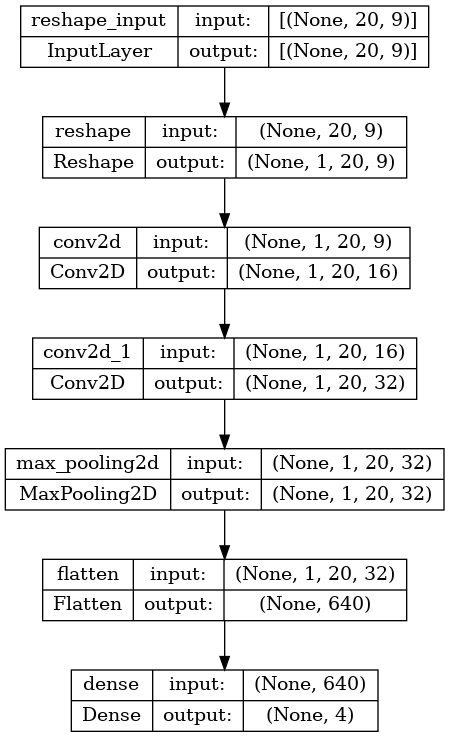

In [38]:
#Definición del modelo
modelo = Sequential()
# modelo.add(Conv1D(16,3, activation="relu", padding="same", input_shape=(20,9),))
# modelo.add(Conv1D(32,3, activation="relu", padding="same", input_shape=(20,9)))
# modelo.add(MaxPooling1D(pool_size=2, strides=2,padding="same"))
modelo.add(Reshape((1,20,9),input_shape=(20,9)))
modelo.add(Conv2D(16,(3,1), activation="relu", padding="same"))
modelo.add(Conv2D(32,(3,1), activation="relu", padding="same"))
modelo.add(MaxPooling2D(pool_size=(2,1), strides=(2,1),padding="same"))
modelo.add(Flatten())
modelo.add(Dense(4,activation="softmax"))

modelo.summary()

keras.utils.plot_model(modelo, to_file='model_HAR_conv1D.png', show_shapes=True, show_layer_names=True)

In [39]:
np.expand_dims(Xtrain,axis=1).shape

(32, 1, 20, 9)

In [40]:
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = modelo.fit(np.expand_dims(Xtrain,axis=1),Ytrain, epochs=100,batch_size=1)
history = modelo.fit(Xtrain,Ytrain, epochs=100,batch_size=1)


Epoch 1/100


2022-06-12 17:18:41.032286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-06-12 17:22:31.886470: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-12 17:22:31.887517: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-06-12 17:22:31.887546: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-06-12 17:22:31.888194: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be o

32/32 [==============================] - 560s 3ms/step - loss: 1.3418 - accuracy: 0.3750
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 1.1178 - accuracy: 0.7500
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8227 - accuracy: 0.8438
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.5319 - accuracy: 0.9688
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.3090 - accuracy: 1.0000
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1796 - accuracy: 1.0000
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1042 - accuracy: 1.0000
Epoch 8/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0610 - accuracy: 1.0000
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0401 - accuracy: 1.0000
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0286 - accuracy: 1.0000
Epoch 11/100
32/32 

32/32 [==============================] - 0s 2ms/step - loss: 1.4222e-04 - accuracy: 1.0000
Epoch 82/100
32/32 [==============================] - 0s 2ms/step - loss: 1.3763e-04 - accuracy: 1.0000
Epoch 83/100
32/32 [==============================] - 0s 2ms/step - loss: 1.3484e-04 - accuracy: 1.0000
Epoch 84/100
32/32 [==============================] - 0s 2ms/step - loss: 1.2961e-04 - accuracy: 1.0000
Epoch 85/100
32/32 [==============================] - 0s 2ms/step - loss: 1.2642e-04 - accuracy: 1.0000
Epoch 86/100
32/32 [==============================] - 0s 2ms/step - loss: 1.2243e-04 - accuracy: 1.0000
Epoch 87/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1847e-04 - accuracy: 1.0000
Epoch 88/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1580e-04 - accuracy: 1.0000
Epoch 89/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1140e-04 - accuracy: 1.0000
Epoch 90/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0

In [41]:
# Save the model to disk
modelo.save(MODEL_TF+"_conv1d")

INFO:tensorflow:Assets written to: ./models/model_conv1d/assets


INFO:tensorflow:Assets written to: ./models/model_conv1d/assets


In [42]:
modelo.evaluate(Xtest, Ytest)
# modelo.evaluate(np.expand_dims(Xtest,axis=1), Ytest)

1/1 [==============================] - 0s 256ms/step - loss: 1.2273e-04 - accuracy: 1.0000


[0.0001227272441610694, 1.0]

1/1 [==============================] - 0s 46ms/step - loss: 8.0224e-05 - accuracy: 1.0000


[8.02244248916395e-05, 1.0]

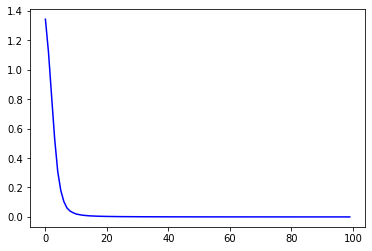

In [43]:
plt.plot(history.history["loss"],'b')
modelo.evaluate(Xtrain, Ytrain)
# modelo.evaluate(np.expand_dims(Xtrain,axis=1), Ytrain)

In [44]:
Ypred_conv1D=modelo.predict(Xtest)
# Ypred_conv1D=modelo.predict(np.expand_dims(Xtest,axis=1))


print(np.argmax(Ypred_conv1D,axis=1)==YtestIni)

1/1 [==============================] - 0s 98ms/step
[[ True  True False False False False False False]
 [ True  True False False False False False False]
 [False False  True  True False False False False]
 [False False  True  True False False False False]
 [False False False False  True  True False False]
 [False False False False  True  True False False]
 [False False False False False False  True  True]
 [False False False False False False  True  True]]


1/1 [==============================] - 0s 18ms/step


2.0

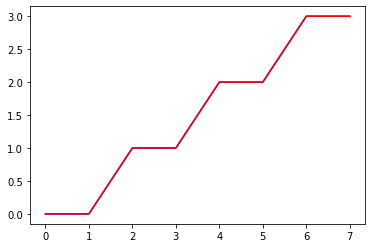

In [45]:
#Predicción de un paso
Ypred_conv1D=modelo.predict(Xtest)
# Ypred_conv1D=modelo.predict(np.expand_dims(Xtest,axis=1))
Ypred_conv1D_argmax=np.argmax(Ypred_conv1D,axis=1)
plt.plot(YtestIni,'b',Ypred_conv1D_argmax,'r')
np.mean(keras.losses.mean_squared_error(YtestIni, Ypred_conv1D_argmax))

## Modelo con Redes recurrentes simples

(9, 4)
(4, 4)
(4,)
(4, 4)
(4, 4)
(4,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 4)             56        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 36        
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


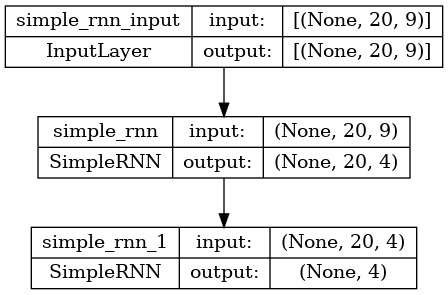

In [46]:
modelo_srnn = keras.models.Sequential([
    keras.layers.SimpleRNN(4, return_sequences=True, input_shape=[20, 9]),
    keras.layers.SimpleRNN(4)
])
"""
modelo_srnn = keras.models.Sequential([
    keras.layers.SimpleRNN(4,input_shape=[None, 1]),
    keras.layers.SimpleRNN(2)
])
"""

Wx = modelo_srnn.layers[0].get_weights()[0]
print(Wx.shape)
Wh = modelo_srnn.layers[0].get_weights()[1]
print(Wh.shape)
b = modelo_srnn.layers[0].get_weights()[2]
print(b.shape)

Wx1 = modelo_srnn.layers[1].get_weights()[0]
print(Wx1.shape)
Wh1 = modelo_srnn.layers[1].get_weights()[1]
print(Wh1.shape)
b1 = modelo_srnn.layers[1].get_weights()[2]
print(b1.shape)
modelo_srnn.summary()
keras.utils.plot_model(modelo_srnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/100


/home/sergio/.pythonvenv/notebook/jupyterenv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 1.0393 - val_loss: 1.0101
Epoch 2/100
1/1 [==============================] - 0s 38ms/step - loss: 1.0140 - val_loss: 0.9817
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.9872 - val_loss: 0.9536
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 0.9612 - val_loss: 0.9342
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 0.9439 - val_loss: 0.9255
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.9360 - val_loss: 0.9107
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 0.9223 - val_loss: 0.8906
Epoch 8/100
1/1 [==============================] - 0s 41ms/step - loss: 0.9027 - val_loss: 0.8723
Epoch 9/100
1/1 [==============================] - 0s 40ms/step - loss: 0.8839 - val_loss: 0.8578
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 0.8689 - val_loss: 0.8435
Epoch 11/100
1/1 [===============

Epoch 84/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0941 - val_loss: 0.1669
Epoch 85/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0929 - val_loss: 0.1660
Epoch 86/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0917 - val_loss: 0.1650
Epoch 87/100
1/1 [==============================] - 0s 53ms/step - loss: 0.0905 - val_loss: 0.1641
Epoch 88/100
1/1 [==============================] - 0s 56ms/step - loss: 0.0893 - val_loss: 0.1627
Epoch 89/100
1/1 [==============================] - 0s 57ms/step - loss: 0.0882 - val_loss: 0.1615
Epoch 90/100
1/1 [==============================] - 0s 54ms/step - loss: 0.0871 - val_loss: 0.1600
Epoch 91/100
1/1 [==============================] - 0s 65ms/step - loss: 0.0862 - val_loss: 0.1583
Epoch 92/100
1/1 [==============================] - 0s 65ms/step - loss: 0.0852 - val_loss: 0.1565
Epoch 93/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0841 - val_loss: 0.1546
Epoch 94/1

0.13943354785442352

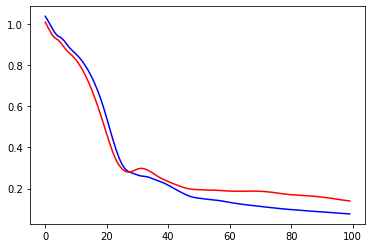

In [47]:
optimizer = keras.optimizers.Adam(lr=0.005)
modelo_srnn.compile(loss="mse", optimizer=optimizer)
# modelo_srnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = modelo_srnn.fit(Xtrain, Ytrain, epochs=100,validation_data=(Xtest, Ytest))
plt.plot(history.history["loss"],'b',history.history["val_loss"],'r')
modelo_srnn.evaluate(Xtest, Ytest)

In [48]:
# Save the model to disk
modelo_srnn.save(MODEL_TF+"_srnn")

INFO:tensorflow:Assets written to: ./models/model_srnn/assets


INFO:tensorflow:Assets written to: ./models/model_srnn/assets


1/1 [==============================] - 0s 200ms/step


2.25

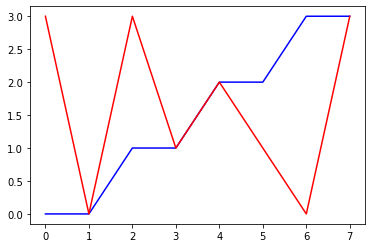

In [49]:
#Predicción de un paso
Ypredic1=modelo_srnn.predict(Xtest)
Ypredic1_argmax=np.argmax(Ypredic1,axis=1)
plt.plot(YtestIni,'b',Ypredic1_argmax,'r')
np.mean(keras.losses.mean_squared_error(YtestIni, Ypredic1_argmax))

## Modelo con LSTM

(9, 40)
(10, 40)
(40,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                800       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               1100      
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 2,304
Trainable params: 2,304
Non-trainable params: 0
_________________________________________________________________


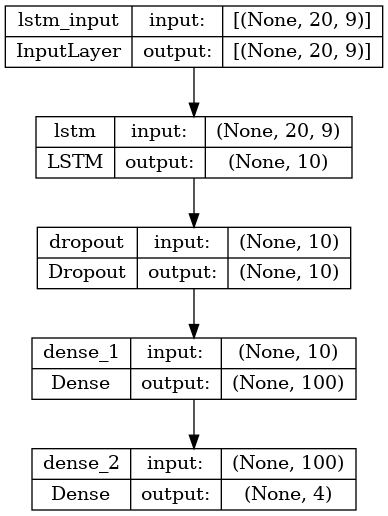

In [50]:
model_lstm = Sequential()
model_lstm.add(keras.layers.LSTM(10, input_shape=[20,9]))
model_lstm.add(keras.layers.Dropout(0.5))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(4, activation='softmax'))
# model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Wx = model_lstm.layers[0].get_weights()[0]
print(Wx.shape)
Wh = model_lstm.layers[0].get_weights()[1]
print(Wh.shape)
b = model_lstm.layers[0].get_weights()[2]
print(b.shape)

# Wx1 = model_lstm.layers[1].get_weights()[0]
# print(Wx1.shape)
# Wh1 = model_lstm.layers[1].get_weights()[1]
# print(Wh1.shape)
# b1 = model_lstm.layers[1].get_weights()[2]
# print(b1.shape)
model_lstm.summary()
keras.utils.plot_model(model_lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [51]:
# optimizer = keras.optimizers.Adam(lr=0.005,)
optimizer = keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# model_lstm.compile(loss="mse", optimizer=optimizer)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_lstm.fit(Xtrain, Ytrain, epochs=200,validation_data=(Xtest, Ytest), batch_size=1)


Epoch 1/200
32/32 [==============================] - 543s 12ms/step - loss: 1.3215 - accuracy: 0.3438 - val_loss: 1.0933 - val_accuracy: 0.6250
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9893 - accuracy: 0.5312 - val_loss: 0.6694 - val_accuracy: 0.8750
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 0.7862 - accuracy: 0.7188 - val_loss: 0.8580 - val_accuracy: 0.7500
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 0.8792 - accuracy: 0.6250 - val_loss: 0.5336 - val_accuracy: 0.6250
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.7500 - val_loss: 0.2015 - val_accuracy: 1.0000
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.3054 - accuracy: 0.9688 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.9688 - val_loss: 0.0270 - val_accuracy: 1.0000
Epoch 8/20

Epoch 58/200
32/32 [==============================] - 0s 4ms/step - loss: 0.2023 - accuracy: 0.9375 - val_loss: 2.9488e-05 - val_accuracy: 1.0000
Epoch 59/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9688 - val_loss: 8.6754e-05 - val_accuracy: 1.0000
Epoch 60/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0252 - accuracy: 1.0000 - val_loss: 9.3100e-05 - val_accuracy: 1.0000
Epoch 61/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 9.1268e-05 - val_accuracy: 1.0000
Epoch 62/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9062 - val_loss: 7.3452e-05 - val_accuracy: 1.0000
Epoch 63/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1088 - accuracy: 0.9688 - val_loss: 5.9046e-05 - val_accuracy: 1.0000
Epoch 64/200
32/32 [==============================] - 0s 3ms/step - loss: 0.5342 - accuracy: 0.9062 - val_loss: 0.0358 - val

32/32 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 4.3075e-04 - val_accuracy: 1.0000
Epoch 115/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.9688 - val_loss: 2.1130e-04 - val_accuracy: 1.0000
Epoch 116/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.7757e-04 - val_accuracy: 1.0000
Epoch 117/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0745 - accuracy: 0.9688 - val_loss: 1.7613e-04 - val_accuracy: 1.0000
Epoch 118/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0942 - accuracy: 0.9375 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 119/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.9062 - val_loss: 1.0622e-04 - val_accuracy: 1.0000
Epoch 120/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0562 - accuracy: 0.9688 - val_loss: 7.9653e-04 - val_accura

Epoch 171/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1516 - accuracy: 0.9062 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 172/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0918 - accuracy: 1.0000 - val_loss: 0.0909 - val_accuracy: 0.8750
Epoch 173/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9688 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 174/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 175/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 176/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9688 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 177/200
32/32 [==============================] - 0s 3ms/step - loss: 0.1254 - accuracy: 0.9688 - val_loss: 0.0082 - val_accuracy: 1.0000

In [52]:
# Save the model to disk
model_lstm.save(MODEL_TF+"_lstm")

INFO:tensorflow:Assets written to: ./models/model_lstm/assets


INFO:tensorflow:Assets written to: ./models/model_lstm/assets


1/1 [==============================] - 0s 328ms/step - loss: 0.0019 - accuracy: 1.0000


[0.0018589599058032036, 1.0]

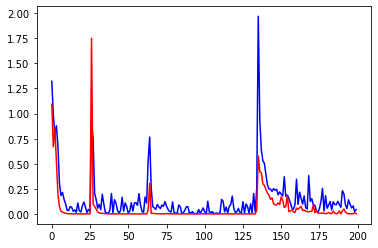

In [53]:
plt.plot(history.history["loss"],'b',history.history["val_loss"],'r')
model_lstm.evaluate(Xtest, Ytest)

1/1 [==============================] - 0s 401ms/step


2.0

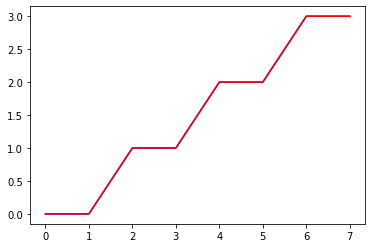

In [54]:
#Predicción de un paso
Ypredic2=model_lstm.predict(Xtest)
Ypredic2_argmax=np.argmax(Ypredic2,axis=1)
plt.plot(YtestIni,'b',Ypredic2_argmax,'r')
np.mean(keras.losses.mean_squared_error(YtestIni, Ypredic2_argmax))

# Graficando metricas

## Matriz confusion Conv1D

1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[2 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 2]]


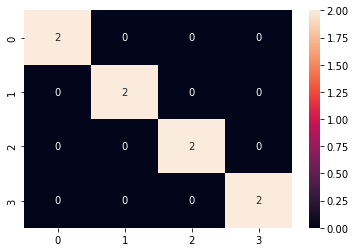

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ypredic=modelo.predict(Xtest)
# ypredic=modelo.predict(np.expand_dims(Xtest,axis=1))

y_test_class = np.argmax(Ytest,axis=1) 
y_pred_class = np.argmax(ypredic,axis=1) 

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
cm1 = confusion_matrix(y_test_class, y_pred_class)
print(cm1)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm1)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

## Matriz de Red recurrente simple

1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2
           2       1.00      0.50      0.67         2
           3       0.33      0.50      0.40         2

    accuracy                           0.50         8
   macro avg       0.58      0.50      0.52         8
weighted avg       0.58      0.50      0.52         8

[[1 0 0 1]
 [0 1 0 1]
 [0 1 1 0]
 [1 0 0 1]]


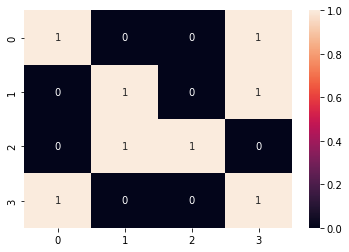

In [56]:
ypredic_simple=modelo_srnn.predict(Xtest)

y_test_class = np.argmax(Ytest,axis=1) 
y_pred_class_simple = np.argmax(ypredic_simple,axis=1) 

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class_simple)) # Precision , Recall, F1-Score & Support
cm_simple = confusion_matrix(y_test_class, y_pred_class_simple)
print(cm_simple)
# visualize the confusion matrix in a heat map
df_cm_simple = pd.DataFrame(cm_simple)
heatmap_simple = sns.heatmap(df_cm_simple, annot=True, fmt="d")

## Matriz confusion de LSTM

1/1 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[2 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 0 2]]


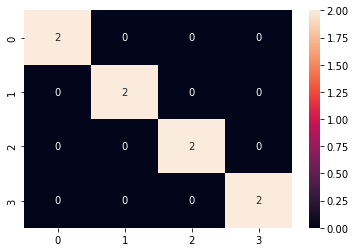

In [57]:
ypredic_lstm=model_lstm.predict(Xtest)

y_test_class = np.argmax(Ytest,axis=1) 
y_pred_class_lstm = np.argmax(ypredic_lstm,axis=1) 

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class_lstm)) # Precision , Recall, F1-Score & Support
cm_lstm = confusion_matrix(y_test_class, y_pred_class_lstm)
print(cm_lstm)
# visualize the confusion matrix in a heat map
df_cm_lstm = pd.DataFrame(cm_lstm)
heatmap_lstm = sns.heatmap(df_cm_lstm, annot=True, fmt="d")

# Generando TF Lite

# Definir constantes

In [58]:
# Define paths to model files
import os
MODELS_DIR = './models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Sin cuantizar para 


### Conv1D

In [59]:
MODEL_TF_CONV1D = MODELS_DIR + 'model_conv1d'
MODEL_NO_QUANT_TFLITE_CONV1D = MODELS_DIR + 'model_no_quant_conv1d.tflite'
MODEL_TFLITE_CONV1D = MODELS_DIR + 'model_conv1d.tflite'
MODEL_TFLITE_MICRO_CONV1D = MODELS_DIR + 'model_conv1d.cc'

In [60]:
converter_conv1d = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF_CONV1D)
model_no_quant_tflite_conv1d = converter_conv1d.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE_CONV1D, "wb").write(model_no_quant_tflite_conv1d)

2022-06-12 17:34:54.458517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-12 17:34:54.458547: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-12 17:34:54.459267: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./models/model_conv1d
2022-06-12 17:34:54.460846: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-12 17:34:54.460963: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: ./models/model_conv1d
2022-06-12 17:34:54.464589: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-06-12 17:34:54.465491: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-12 17:34:54.506251: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./models/model

22168

### SRNN

In [61]:
MODEL_TF_SRNN = MODELS_DIR + 'model_srnn'
MODEL_NO_QUANT_TFLITE_SRNN = MODELS_DIR + 'model_no_quant_srnn.tflite'
MODEL_TFLITE_SRNN = MODELS_DIR + 'model_srnn.tflite'
MODEL_TFLITE_MICRO_SRNN = MODELS_DIR + 'model_srnn.cc'

In [62]:
converter_srnn = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF_SRNN)

converter_srnn.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

# converter_srnn.optimizations = [tf.lite.Optimize.DEFAULT]
# converter_srnn.experimental_new_converter = True # allows conversion of MLIR operators.
# converter_srnn.allow_custom_ops = True

model_no_quant_tflite_srnn = converter_srnn.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE_SRNN, "wb").write(model_no_quant_tflite_srnn)

2022-06-12 17:34:55.577702: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-12 17:34:55.577765: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-12 17:34:55.578024: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./models/model_srnn
2022-06-12 17:34:55.584236: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-12 17:34:55.584307: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: ./models/model_srnn
2022-06-12 17:34:55.604771: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-12 17:34:55.692535: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./models/model_srnn
2022-06-12 17:34:55.753939: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Too

14660

### LSTM

In [63]:
MODEL_TF_LSTM = MODELS_DIR + 'model_lstm'
MODEL_NO_QUANT_TFLITE_LSTM = MODELS_DIR + 'model_no_quant_lstm.tflite'
MODEL_TFLITE_LSTM = MODELS_DIR + 'model_lstm.tflite'
MODEL_TFLITE_MICRO_LSTM = MODELS_DIR + 'model_lstm.cc'

In [64]:
converter_lstm = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF_LSTM)

converter_lstm.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

model_no_quant_tflite_lstm = converter_lstm.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE_LSTM, "wb").write(model_no_quant_tflite_lstm)

2022-06-12 17:34:57.773544: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-12 17:34:57.773581: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-12 17:34:57.773756: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./models/model_lstm
2022-06-12 17:34:57.784476: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-12 17:34:57.784511: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: ./models/model_lstm
2022-06-12 17:34:57.819486: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-12 17:34:57.917808: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./models/model_lstm
2022-06-12 17:34:57.987648: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Too

19412

## Modelo cuantizado para:

### Conv1D

In [65]:
def representative_dataset():
  for i in range(16):
    yield([Xtrain[i].reshape(1,20,9).astype(np.float32)])

In [66]:
def representative_dataset2():
  for i in range(16):
    yield([Xtrain[i].reshape(1,1,20,9).astype(np.float32)])

In [67]:
# Set the optimization flag.
converter_conv1d.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter_conv1d.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_conv1d.inference_input_type = tf.int8
converter_conv1d.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter_conv1d.representative_dataset = representative_dataset
model_tflite_conv1d = converter_conv1d.convert()

# Save the model to disk
open(MODEL_TFLITE_CONV1D, "wb").write(model_tflite_conv1d)

2022-06-12 17:34:58.314318: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-12 17:34:58.314351: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-12 17:34:58.314512: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./models/model_conv1d
2022-06-12 17:34:58.316083: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-12 17:34:58.316109: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: ./models/model_conv1d
2022-06-12 17:34:58.319520: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-12 17:34:58.359972: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./models/model_conv1d
2022-06-12 17:34:58.374387: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: O

10208

### SRNN

In [68]:
# Set the optimization flag.
converter_srnn.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization

converter_srnn.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS_INT8, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]


# converter_srnn.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_srnn.inference_input_type = tf.int8
converter_srnn.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter_srnn.representative_dataset = representative_dataset
model_tflite_srnn = converter_srnn.convert()

# Save the model to disk
open(MODEL_TFLITE_SRNN, "wb").write(model_tflite_srnn)

2022-06-12 17:34:58.579942: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-12 17:34:58.579980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-12 17:34:58.580182: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./models/model_srnn
2022-06-12 17:34:58.584614: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-12 17:34:58.584640: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: ./models/model_srnn
2022-06-12 17:34:58.597383: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-12 17:34:58.655462: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./models/model_srnn
2022-06-12 17:34:58.693890: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Too

18616

### LSTM

In [69]:
# Set the optimization flag.
converter_lstm.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization

converter_lstm.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS_INT8, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

# converter_lstm.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_lstm.inference_input_type = tf.int8
converter_lstm.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter_lstm.representative_dataset = representative_dataset
model_tflite_lstm = converter_lstm.convert()

# Save the model to disk
open(MODEL_TFLITE_LSTM, "wb").write(model_tflite_lstm)

2022-06-12 17:34:59.198517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-12 17:34:59.198555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-12 17:34:59.198734: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./models/model_lstm
2022-06-12 17:34:59.206250: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-12 17:34:59.206296: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: ./models/model_lstm
2022-06-12 17:34:59.232516: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-12 17:34:59.332570: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./models/model_lstm
2022-06-12 17:34:59.399386: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Too

15192

## Comparando modelos

### funciones de ayuda para la prediccion

In [70]:
def predict_tflite(tflite_model, x_test):
  
#   nombre_modelo = tflite_model[tflite_model.find(".tf")-4:-7]
#   print("nombre_modelo: ",nombre_modelo)
#   if nombre_modelo == "nv1d":
#     x_test = np.expand_dims(x_test,axis=1)
  # Prepare the test data
  x_test_ = x_test.copy()
#   print("x_test_ copia:", x_test_.shape)
#   x_test_ = x_test_.reshape((x_test.size, 1))
#   x_test_ = x_test_.reshape((x_test.shape[0],x_test.shape[1], x_test.shape[2]))
  x_test_ = x_test_.astype(np.float32)
  
#   print("x_test_ procesada: ",x_test_.shape)

  # Initialize the TFLite interpreter
#   interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter = tf.lite.Interpreter(model_path=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
#   y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  y_pred = np.empty((len(x_test_),output_details["shape"][1]), dtype=output_details["dtype"])

#   print("y_pred creacion: ",y_pred.shape)
#   print("Len x_test_ : ",len(x_test_))
#   print("index: ",input_details["index"])

  for i in range(len(x_test_)):
    
#     print(f"x_test_[{i}] shape", len([x_test_[i]]))
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
#     print("tensor interprete: ", interpreter.get_tensor(input_details["index"]).shape)
    interpreter.invoke()
    # print("interpreter.invoke()",interpreter.invoke())
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
#     print("y_pred[{0}]: {1}".format(i,y_pred[i]))
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  # print("output_scale: {0} \noutput_zero_point: {1}".format(output_scale, output_zero_point))
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global modelo_conv1d, modelo_srnn, model_lstm

  nombre_modelo = tflite_model[tflite_model.find(".tf")-4:-7]
  print("nombre_modelo: ",nombre_modelo)
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function=tf.keras.losses.get(modelo_conv1d.loss)
  if nombre_modelo == "nv1d":
    loss_function = tf.keras.losses.get(modelo_conv1d.loss)
  elif nombre_modelo == "srnn":
    loss_function = tf.keras.losses.get(modelo_srnn.loss)
  elif nombre_modelo == "lstm":
    loss_function = tf.keras.losses.get(model_lstm.loss)
  print("funcion: ",loss_function)
  loss = loss_function(y_true, y_pred).numpy().mean()
  return loss

In [71]:
tflite_model = MODEL_NO_QUANT_TFLITE_CONV1D
print(tflite_model[tflite_model.find(".tf")-4:-7])

nv1d


### Conv1D

In [72]:
MODEL_TF_CONV1D = MODELS_DIR + 'model_conv1d'
MODEL_NO_QUANT_TFLITE_CONV1D = MODELS_DIR + 'model_no_quant_conv1d.tflite'
MODEL_TFLITE_CONV1D = MODELS_DIR + 'model_conv1d.tflite'
MODEL_TFLITE_MICRO_CONV1D = MODELS_DIR + 'model_conv1d.cc'

In [73]:
# Cargar modelo

modelo_conv1d = tf.keras.models.load_model(MODEL_TF_CONV1D)

In [74]:
# Calculate predictions

y_test_pred_tf_conv1d = modelo_conv1d.predict(Xtest)
# y_test_pred_tf_conv1d = modelo_conv1d.predict(np.expand_dims(Xtest,axis=1))
y_test_pred_no_quant_tflite_conv1d = predict_tflite(MODEL_NO_QUANT_TFLITE_CONV1D, Xtest)
y_test_pred_tflite_conv1d = predict_tflite(MODEL_TFLITE_CONV1D, Xtest)

1/1 [==============================] - 0s 74ms/step


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<Figure size 432x288 with 0 Axes>

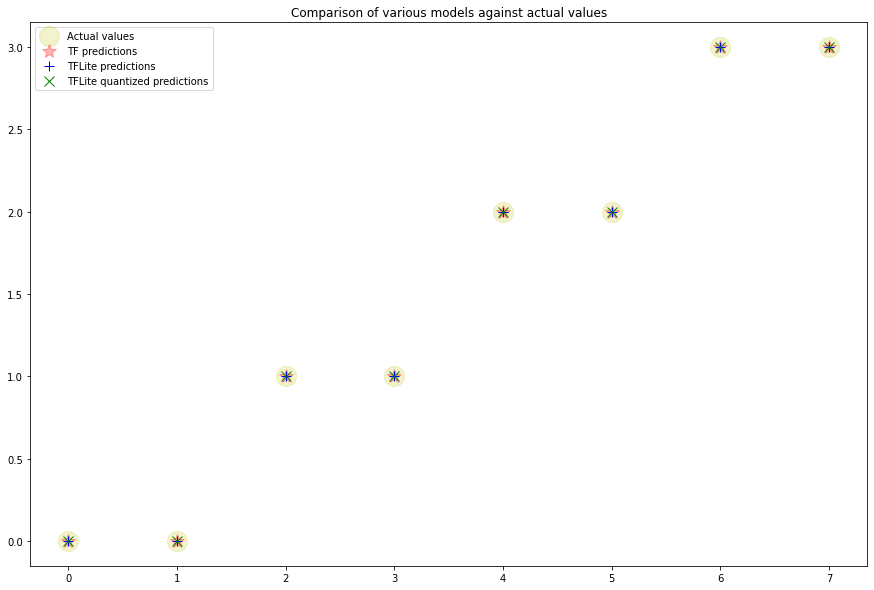

In [75]:
# Compare predictions
plt.clf()
plt.figure(figsize=(15,10))
plt.title('Comparison of various models against actual values')
plt.plot(np.argmax(Ytest,axis=1), 'yo', label='Actual values', markersize = 20, alpha=0.2)
plt.plot(np.argmax(y_test_pred_tf_conv1d,axis=1), 'r*', label='TF predictions', markersize = 15, alpha=0.3)
plt.plot(np.argmax(y_test_pred_no_quant_tflite_conv1d,axis=1), 'b+', label='TFLite predictions', markersize=10)
plt.plot(np.argmax(y_test_pred_tflite_conv1d, axis=1), 'gx', label='TFLite quantized predictions', markersize=10)
plt.legend()
plt.show()

### SRNN

In [76]:
MODEL_TF_SRNN = MODELS_DIR + 'model_srnn'
MODEL_NO_QUANT_TFLITE_SRNN = MODELS_DIR + 'model_no_quant_srnn.tflite'
MODEL_TFLITE_SRNN = MODELS_DIR + 'model_srnn.tflite'
MODEL_TFLITE_MICRO_SRNN = MODELS_DIR + 'model_srnn.cc'

In [77]:
# Cargar modelo

modelo_srnn = tf.keras.models.load_model(MODEL_TF_SRNN)

In [78]:
# Calculate predictions

y_test_pred_tf_srnn = modelo_srnn.predict(Xtest)
y_test_pred_no_quant_tflite_srnn = predict_tflite(MODEL_NO_QUANT_TFLITE_SRNN, Xtest)
y_test_pred_tflite_srnn = predict_tflite(MODEL_TFLITE_SRNN, Xtest)

1/1 [==============================] - 0s 181ms/step


2022-06-12 17:35:01.460845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:01.461111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:01.461269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:01.461492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:01.461660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

<Figure size 432x288 with 0 Axes>

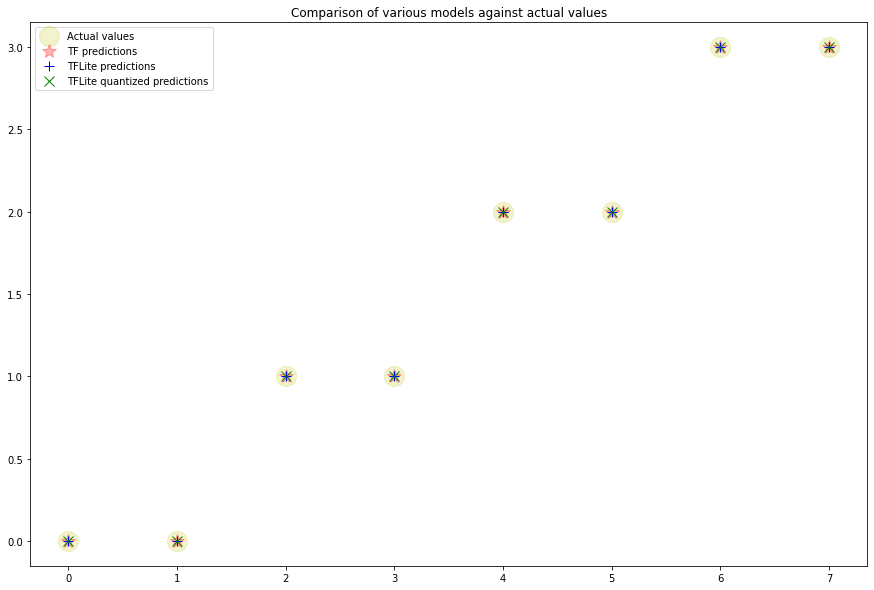

In [79]:
# Compare predictions
plt.clf()
plt.figure(figsize=(15,10))
plt.title('Comparison of various models against actual values')
plt.plot(np.argmax(Ytest,axis=1), 'yo', label='Actual values', markersize = 20, alpha=0.2)
plt.plot(np.argmax(y_test_pred_tf_conv1d,axis=1), 'r*', label='TF predictions', markersize = 15, alpha=0.3)
plt.plot(np.argmax(y_test_pred_no_quant_tflite_conv1d,axis=1), 'b+', label='TFLite predictions', markersize=10)
plt.plot(np.argmax(y_test_pred_tflite_conv1d, axis=1), 'gx', label='TFLite quantized predictions', markersize=10)
plt.legend()
plt.show()

### LSTM

In [80]:
MODEL_TF_LSTM = MODELS_DIR + 'model_lstm'
MODEL_NO_QUANT_TFLITE_LSTM = MODELS_DIR + 'model_no_quant_lstm.tflite'
MODEL_TFLITE_LSTM = MODELS_DIR + 'model_lstm.tflite'
MODEL_TFLITE_MICRO_LSTM = MODELS_DIR + 'model_lstm.cc'

In [81]:
# Cargar modelo

modelo_lstm = tf.keras.models.load_model(MODEL_TF_LSTM)

In [82]:
# Calculate predictions

y_test_pred_tf_lstm = modelo_lstm.predict(Xtest)
y_test_pred_no_quant_tflite_lstm = predict_tflite(MODEL_NO_QUANT_TFLITE_LSTM, Xtest)
y_test_pred_tflite_lstm = predict_tflite(MODEL_TFLITE_LSTM, Xtest)

1/1 [==============================] - 0s 318ms/step


2022-06-12 17:35:03.942510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:03.942754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:03.942914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:03.943119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:03.943280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

<Figure size 432x288 with 0 Axes>

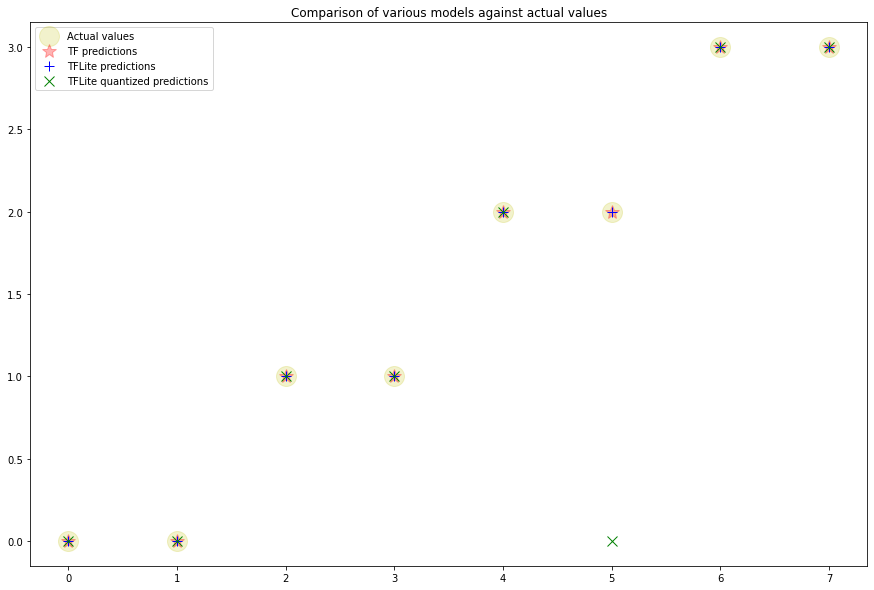

In [83]:
# Compare predictions
plt.clf()
plt.figure(figsize=(15,10))
plt.title('Comparison of various models against actual values')
plt.plot(np.argmax(Ytest,axis=1), 'yo', label='Actual values', markersize = 20, alpha=0.2)
plt.plot(np.argmax(y_test_pred_tf_lstm,axis=1), 'r*', label='TF predictions', markersize = 15, alpha=0.3)
plt.plot(np.argmax(y_test_pred_no_quant_tflite_lstm,axis=1), 'b+', label='TFLite predictions', markersize=10)
plt.plot(np.argmax(y_test_pred_tflite_lstm, axis=1), 'gx', label='TFLite quantized predictions', markersize=10)
plt.legend()
plt.show()

# Generando TF Lite para el microcontrolador

## Loss de cada modelo

### Conv1d

In [84]:
# Calculate loss
loss_tf_conv1d, _ = modelo_conv1d.evaluate(Xtest, Ytest, verbose=0)
# loss_tf_conv1d, _ = modelo_conv1d.evaluate(np.expand_dims(Xtest,axis=1), Ytest, verbose=0)
loss_no_quant_tflite_conv1d = evaluate_tflite(MODEL_NO_QUANT_TFLITE_CONV1D, Xtest, Ytest)
loss_tflite_conv1d = evaluate_tflite(MODEL_TFLITE_CONV1D, Xtest, Ytest)

nombre_modelo:  nv1d
funcion:  <function categorical_crossentropy at 0x7f1648f71b40>
nombre_modelo:  nv1d
funcion:  <function categorical_crossentropy at 0x7f1648f71b40>


In [85]:
print("Loss conv1d: ",loss_tf_conv1d)
print("Loss tflite conv1d: ",loss_no_quant_tflite_conv1d)
print("Loss tflite quantized conv1d",loss_tflite_conv1d)

Loss conv1d:  0.0001227272441610694
Loss tflite conv1d:  0.0001227396
Loss tflite quantized conv1d 0.022985764


In [86]:
# Compare loss
import pandas as pd

df_conv1d = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf_conv1d],
     ["TensorFlow Lite", loss_no_quant_tflite_conv1d],
     ["TensorFlow Lite Quantized", loss_tflite_conv1d]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df_conv1d.head()

,Loss/MSE
Model,
TensorFlow,0.0001
TensorFlow Lite,0.0001
TensorFlow Lite Quantized,0.0230


### SRNN

In [87]:
# Calculate loss
loss_tf_srnn = modelo_srnn.evaluate(Xtest, Ytest, verbose=0)
loss_no_quant_tflite_srnn = evaluate_tflite(MODEL_NO_QUANT_TFLITE_SRNN, Xtest, Ytest)
loss_tflite_srnn = evaluate_tflite(MODEL_TFLITE_SRNN, Xtest, Ytest)

nombre_modelo:  srnn
funcion:  <function mean_squared_error at 0x7f1648f708b0>
nombre_modelo:  srnn
funcion:  <function mean_squared_error at 0x7f1648f708b0>


2022-06-12 17:35:04.801904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:04.802187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:04.802368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:04.802597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:04.802781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [88]:
print("Loss srnn: ",loss_tf_srnn)
print("Loss tflite srnn: ",loss_no_quant_tflite_srnn)
print("Loss tflite quantized srnn",loss_tflite_srnn)

Loss srnn:  0.13943354785442352
Loss tflite srnn:  0.13954732
Loss tflite quantized srnn 0.16133082


In [89]:
# Compare loss
import pandas as pd

df_srnn = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf_srnn],
     ["TensorFlow Lite", loss_no_quant_tflite_srnn],
     ["TensorFlow Lite Quantized", loss_tflite_srnn]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df_srnn.head()

,Loss/MSE
Model,
TensorFlow,0.1394
TensorFlow Lite,0.1395
TensorFlow Lite Quantized,0.1613


### LSTM

In [90]:
# Calculate loss
loss_tf_lstm, _ = model_lstm.evaluate(Xtest, Ytest, verbose=0)
loss_no_quant_tflite_lstm = evaluate_tflite(MODEL_NO_QUANT_TFLITE_LSTM, Xtest, Ytest)
loss_tflite_lstm = evaluate_tflite(MODEL_TFLITE_LSTM, Xtest, Ytest)

nombre_modelo:  lstm
funcion:  <function categorical_crossentropy at 0x7f1648f71b40>
nombre_modelo:  lstm
funcion:  <function categorical_crossentropy at 0x7f1648f71b40>


2022-06-12 17:35:04.903353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:04.903608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:04.903771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:04.903983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 17:35:04.904177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [91]:
print("Loss lstm: ",loss_tf_lstm)
print("Loss tflite lstm: ",loss_no_quant_tflite_lstm)
print("Loss tflite quantized lstm",loss_tflite_lstm)

Loss lstm:  0.0018589599058032036
Loss tflite lstm:  0.0018599803
Loss tflite quantized lstm 2.0167208


In [92]:
# Compare loss
import pandas as pd

df_lstm = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf_lstm],
     ["TensorFlow Lite", loss_no_quant_tflite_lstm],
     ["TensorFlow Lite Quantized", loss_tflite_lstm]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df_lstm.head()

,Loss/MSE
Model,
TensorFlow,0.0019
TensorFlow Lite,0.0019
TensorFlow Lite Quantized,2.0167


## Tamano en Bytes

### Conv1d

In [93]:
# Calculate size
size_tf_conv1d = os.path.getsize(MODEL_TF_CONV1D)
size_no_quant_tflite_conv1d = os.path.getsize(MODEL_NO_QUANT_TFLITE_CONV1D)
size_tflite_conv1d = os.path.getsize(MODEL_TFLITE_CONV1D)

In [94]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Conv1d", f"{size_tf_conv1d} bytes", ""],
     ["TensorFlow Lite Conv1d", f"{size_no_quant_tflite_conv1d} bytes ", f"(reduced by {size_tf_conv1d - size_no_quant_tflite_conv1d} bytes)"],
     ["TensorFlow Lite Quantized Conv1d", f"{size_tflite_conv1d} bytes", f"(reduced by {size_no_quant_tflite_conv1d - size_tflite_conv1d} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow Conv1d,4096 bytes,
TensorFlow Lite Conv1d,22168 bytes,(reduced by -18072 bytes)
TensorFlow Lite Quantized Conv1d,10208 bytes,(reduced by 11960 bytes)


### SRNN

In [95]:
# Calculate size
size_tf_srnn = os.path.getsize(MODEL_TF_SRNN)
size_no_quant_tflite_srnn = os.path.getsize(MODEL_NO_QUANT_TFLITE_SRNN)
size_tflite_srnn = os.path.getsize(MODEL_TFLITE_SRNN)

In [96]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow srnn", f"{size_tf_srnn} bytes", ""],
     ["TensorFlow Lite srnn", f"{size_no_quant_tflite_srnn} bytes ", f"(reduced by {size_tf_srnn - size_no_quant_tflite_srnn} bytes)"],
     ["TensorFlow Lite Quantized srnn", f"{size_tflite_srnn} bytes", f"(reduced by {size_no_quant_tflite_srnn - size_tflite_srnn} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow srnn,4096 bytes,
TensorFlow Lite srnn,14660 bytes,(reduced by -10564 bytes)
TensorFlow Lite Quantized srnn,18616 bytes,(reduced by -3956 bytes)


### LSTM

In [97]:
# Calculate size
size_tf_lstm = os.path.getsize(MODEL_TF_LSTM)
size_no_quant_tflite_lstm = os.path.getsize(MODEL_NO_QUANT_TFLITE_LSTM)
size_tflite_lstm = os.path.getsize(MODEL_TFLITE_LSTM)

In [98]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow lstm", f"{size_tf_lstm} bytes", ""],
     ["TensorFlow Lite lstm", f"{size_no_quant_tflite_lstm} bytes ", f"(reduced by {size_tf_lstm - size_no_quant_tflite_lstm} bytes)"],
     ["TensorFlow Lite Quantized lstm", f"{size_tflite_lstm} bytes", f"(reduced by {size_no_quant_tflite_lstm - size_tflite_lstm} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow lstm,4096 bytes,
TensorFlow Lite lstm,19412 bytes,(reduced by -15316 bytes)
TensorFlow Lite Quantized lstm,15192 bytes,(reduced by 4220 bytes)


# Convirtiendo modelos de TFLite a Microcontrolador

## Conv1d

In [99]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE_CONV1D} > {MODEL_TFLITE_MICRO_CONV1D}
# Update variable names
REPLACE_TEXT_CONV1D = MODEL_TFLITE_CONV1D.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_CONV1D}'/model/g' {MODEL_TFLITE_MICRO_CONV1D}

In [100]:
# Print the C source file
!cat $MODEL_TFLITE_MICRO_CONV1D

unsigned char model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00,
  0x18, 0x15, 0x00, 0x00, 0x28, 0x15, 0x00, 0x00, 0xfc, 0x26, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x22, 0xe9, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff,
  0x16, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x26, 0xe9, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00,
  0x0d, 0x00

In [101]:
!cp $MODEL_TFLITE_MICRO_CONV1D '/home/sergio/Documents/Datos_secuenciales/Laboratorio_2/IMU_Classifier/IMU_Classifier/model_conv1d.h'

In [102]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE_SRNN} > {MODEL_TFLITE_MICRO_SRNN}
# Update variable names
REPLACE_TEXT_SRNN = MODEL_TFLITE_SRNN.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_SRNN}'/model/g' {MODEL_TFLITE_MICRO_SRNN}

In [103]:
# Print the C source file
!cat $MODEL_TFLITE_MICRO_SRNN

unsigned char model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x94, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00, 0x88, 0x06, 0x00, 0x00,
  0x98, 0x06, 0x00, 0x00, 0x84, 0x46, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x3e, 0xd4, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x3c, 0xd6, 0xff, 0xff, 0x31, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x73, 0x69, 0x6d, 0x70,
  0x6c, 0x65, 0x5f, 0x72, 0x6e, 0x6e, 0x5f, 0x31, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x4a, 0xd4, 0xff, 0xff,
  0x04, 0x00

In [104]:
!cp $MODEL_TFLITE_MICRO_SRNN '/home/sergio/Documents/Datos_secuenciales/Laboratorio_2/IMU_Classifier/IMU_Classifier/model_srnn.h'

In [105]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE_LSTM} > {MODEL_TFLITE_MICRO_LSTM}
# Update variable names
REPLACE_TEXT_LSTM = MODEL_TFLITE_LSTM.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_LSTM}'/model/g' {MODEL_TFLITE_MICRO_LSTM}

In [106]:
# Print the C source file
!cat $MODEL_TFLITE_MICRO_LSTM

unsigned char model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x84, 0x00, 0x00, 0x00, 0xd4, 0x00, 0x00, 0x00,
  0x68, 0x0f, 0x00, 0x00, 0x78, 0x0f, 0x00, 0x00, 0xdc, 0x38, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x8e, 0xd6, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x98, 0xd8, 0xff, 0xff,
  0x25, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x32, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x92, 0xd6, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00,
  0x0a, 0x00

In [107]:
!cp $MODEL_TFLITE_MICRO_LSTM '/home/sergio/Documents/Datos_secuenciales/Laboratorio_2/IMU_Classifier/IMU_Classifier/model_lstm.h'